This notebook is a mostly from:
http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

In [1]:
import os
import sys
import platform

import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

try:
    print(sys.version)
    print('Machine: {} {}\n'.format(os.uname().sysname,os.uname().machine))
except:
    # Windows
    print('Machine: {} {}\n'.format(platform.uname().system, platform.uname().machine))
    



3.6.3 |Anaconda, Inc.| (default, Nov  8 2017, 15:10:56) [MSC v.1900 64 bit (AMD64)]
Machine: Windows AMD64



## Get Data

In [2]:
end = '2015-01-01'
start = '2007-01-01'
get_px = lambda x: web.DataReader(x, 'yahoo', start=start, end=end)['Adj Close']

symbols = ['SPY','TLT','MSFT']
# raw adjusted close prices
data = pd.DataFrame({sym:get_px(sym) for sym in symbols})
# log returns
lrets = np.log(data/data.shift(1)).dropna()

In [10]:
data.head()

,MSFT,SPY,TLT
Date,,,
2007-01-03,22.574831,110.520622,60.158772
2007-01-04,22.537027,110.755142,60.523548
2007-01-05,22.408501,109.871742,60.260101
2007-01-08,22.627748,110.379898,60.368141
2007-01-09,22.650431,110.286095,60.368141


In [12]:
lrets.head()

,MSFT,SPY,TLT
Date,,,
2007-01-04,-0.001676,0.002120,0.006045
2007-01-05,-0.005719,-0.008008,-0.004362
2007-01-08,0.009737,0.004614,0.001791
2007-01-09,0.001002,-0.000850,0.000000
2007-01-10,-0.010064,0.003326,-0.004485


## White Noise 

White Noise has serially uncorrelated errors

White Noise has expected mean of errors equal to zero

Serially uncorrelated errors = IID (Independent and identically distributed)

If model is successful at capturing the underlying process, the residuals of the model will be i.i.d and resemble white noise


In [3]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh', title='Time Series Analysis Plots'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

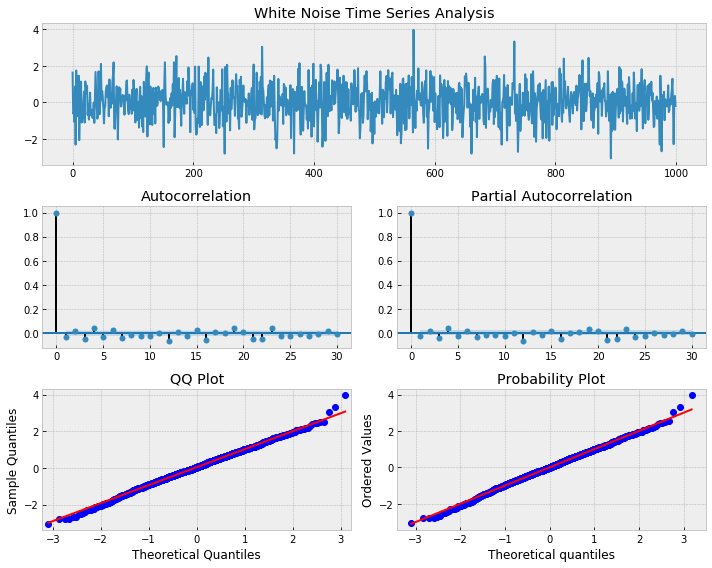

In [4]:
np.random.seed(1)
# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30, title='White Noise Time Series Analysis')

Process appears to be random, and centered about zero

Autocorrelation (ACF) and Partial Autocorrelation (PACF) indicate no significant serial correlation

Distribution appears Normal (QQ Plot)

In [18]:
p("Random Series\n -------------\nmean: {:.3f}\nvariance: {:.3f}\nstandard deviation: {:.3f}"
.format(randser.mean(), randser.var(), randser.std()))

Random Series
 -------------
mean: 0.039
variance: 0.962
standard deviation: 0.981


## Random Walk

Random walk is non-stationary because covariance between observations is time-dependent. 

Random walks are unpredictable

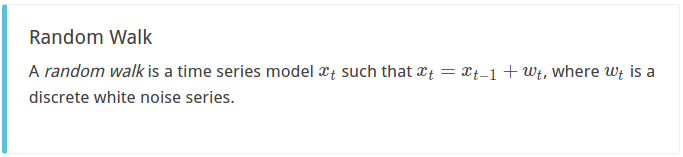

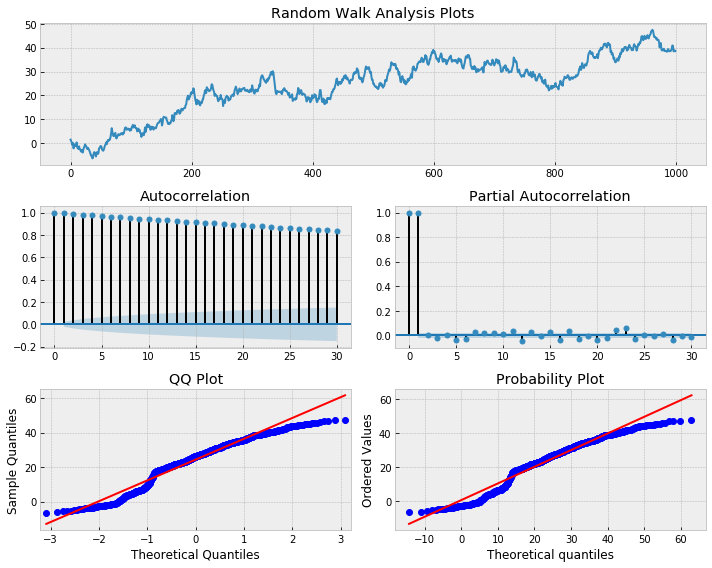

In [24]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
     x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30, title='Random Walk Analysis Plots')

Clearly here the TS is not stationary

Let us check if random walk model is a good fit for our simulated data

Recall that a random walk is: xt = xt-1 + wt

so: wt = xt - xt-1

So the first differences of our random walk series should be equal to a white noise process. Use np.diff()

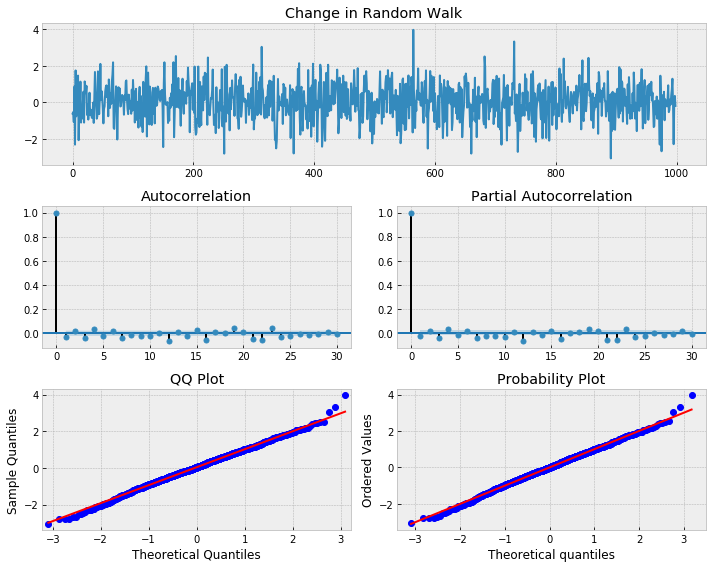

In [25]:
_ = tsplot(np.diff(x), lags=30, title='Change in Random Walk')

Looks exactly like a white noise process. 

Now check to fit a random walk to the first difference of SPY's prices.

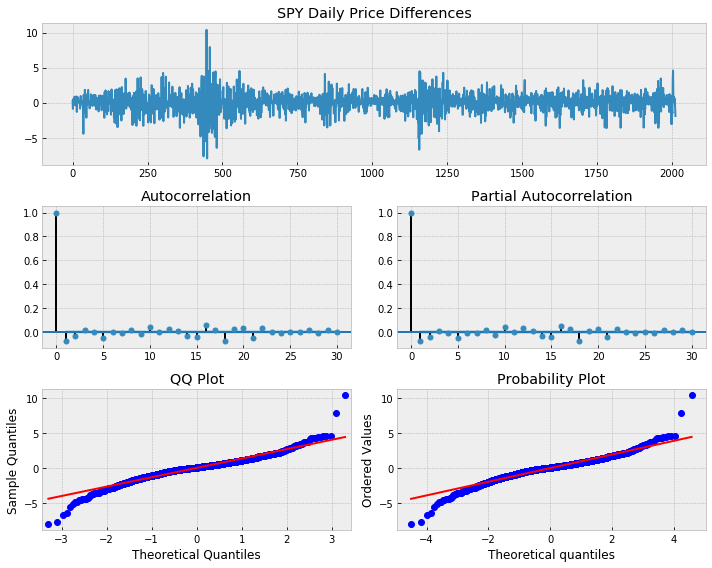

In [30]:
# First difference of SPY prices
_ = tsplot(np.diff(data.SPY), lags=30, title='SPY Daily Price Differences')

Price looks similiar to white noise

Shape of QQ and Probability plots show the process is close to normal but with higher kurtotsis (heavy tails)

Also some significant serial correlation can be seen in the ACF, PACF plots. This indicates better models can be made to describe the actual price change process


## Linear Models

Linear Models = Trend Models (represent TS with straight line)

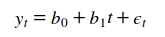

Value of dependent variable is determined by:
    1. beta coefficients
    2. singular independent variable time

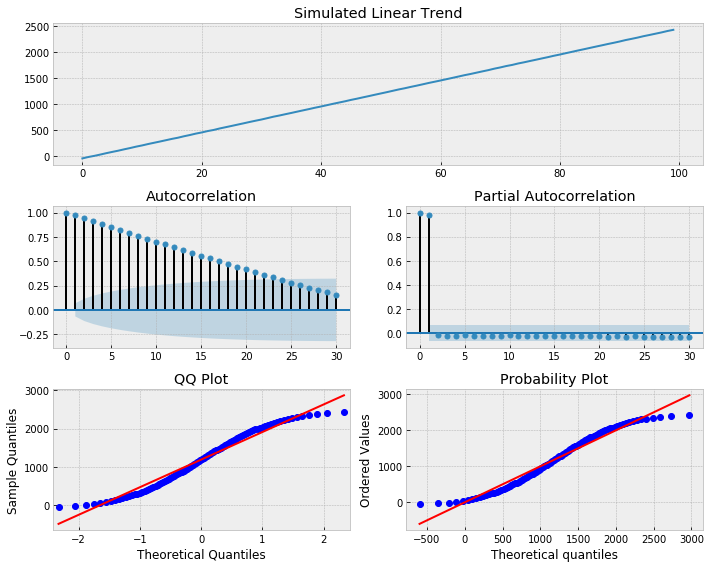

In [32]:
# simulate linear trend
# example Firm ABC sales are -$50 by default and +$25 at every time step

w = np.random.randn(100)
y = np.empty_like(w)

b0 = -50.
b1 = 25.
for t in range(len(w)):
    y[t] = b0 + b1*t + w[t]
    
_ = tsplot(y, lags=30, title='Simulated Linear Trend') 

- Residuals of the model are correlated and linearly decreasing as a function of the lag

- Distribution is approx. Normal

- Obvious autocorrelation present here

- Significance of PACF at lag 1 indicates that an __autoregressive__ model may work

## Log-Linear Models

- Similiar to Linear Models, except data form an expoential function

- Exponential function represents constant rate of change w.r.t. each time step

- Example is firm sales increasing X% at each time step

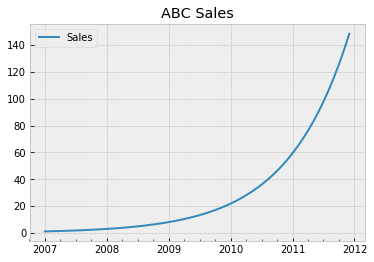

In [37]:
# Simulate ABC exponential growth

# fake dates
idx = pd.date_range('2007-01-01', '2012-01-01', freq='M')

# fake sales increasing at exponential rate
sales = [np.exp( x/12 ) for x in range(1, len(idx)+1)]

# create dataframe and plot
df = pd.DataFrame(sales, columns=['Sales'], index=idx)

with plt.style.context('bmh'):
    df.plot()
    plt.title('ABC Sales')

In [38]:
df.head()

,Sales
2007-01-31,1.086904
2007-02-28,1.181360
2007-03-31,1.284025
2007-04-30,1.395612
2007-05-31,1.516897


- Transform the data by taking natural log. 
- Now linear regression is better fit to the data

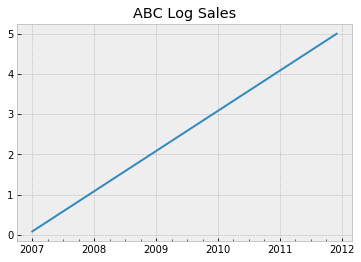

In [39]:
with plt.style.context('bmh'):
    pd.Series(np.log(sales), index=idx).plot()
    plt.title('ABC Log Sales')

In [42]:
df['log_sales'] = np.log(sales)
df.head()

,Sales,log_sales
2007-01-31,1.086904,0.083333
2007-02-28,1.181360,0.166667
2007-03-31,1.284025,0.250000
2007-04-30,1.395612,0.333333
2007-05-31,1.516897,0.416667


## Autoregressive Models - AR(p)

- Dependent variable is regressed against one or more lagged values of itself

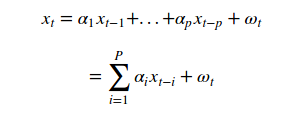

- __order__ is the value p, which is the number of lagged variables used within the model


- Example is AR(2) which is second-order autoregressive model:
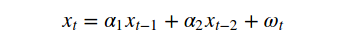
- alpha (a) is the coefficient (cannot equal 0 in AR model)
- omega (w) is a __white noise__ term


- In AR(1) model, if alpha = 1 -> we have a __random walk__
- which is not stationary

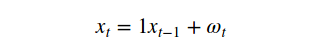

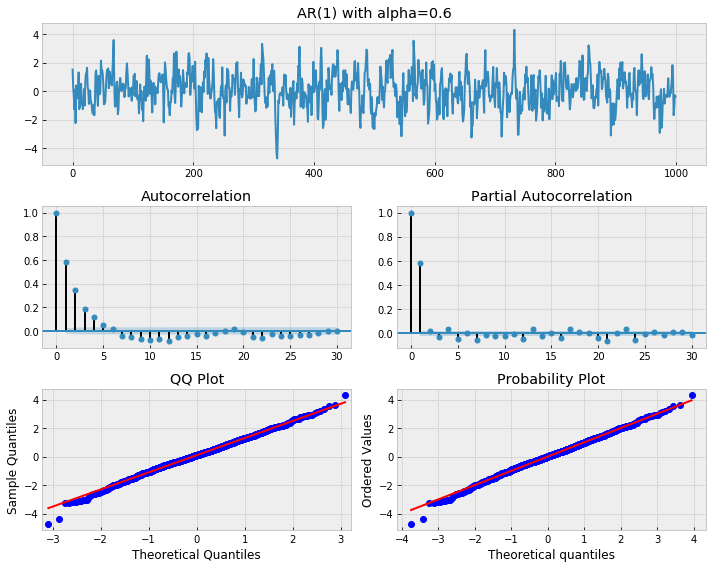

In [82]:
# Simulate an AR(1) process with alpha = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30, title='AR(1) with alpha={}'.format(a))

- Distribution of simulated AR(1) model is normal
- Significant serial correlation between lagged values 
- especially true for lag 1 as can be seen in PACF plot

## Fitting an AR(P)

- Using statsmodel
- Fit AR model to simulated data and return estimated alpha coefficient
- Then use __select_order()__ to see if fitted model will select the correct lag
- If AR model is correct, estimated alpha coefficient will be close to true alpha
- Selected order (p) = 1
- Alpha (a) = 0.6

In [53]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = smt.AR(x).fit(maxlag=30, ic='aic', trend='nc')
%time est_order = smt.AR(x).select_order(maxlag=30, ic='aic', trend='nc')

true_order = 1
p('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order))
p('\ntrue alpha = {} | true order = {}'.format(a, true_order))

Wall time: 14.3 s

alpha estimate: 0.58227 | best lag order = 1

true alpha = 0.6 | true order = 1


- Looks like we recovered underlying parameters of our simulated data
- Next, simulate AR(2) process with:


1. alpha_1 = 0.666
 
2. alpha_2 = -0.33


- Make use of statsmodels __arma_generate_samples()__ function
- This function allows for simulating AR model of arbitrary orders

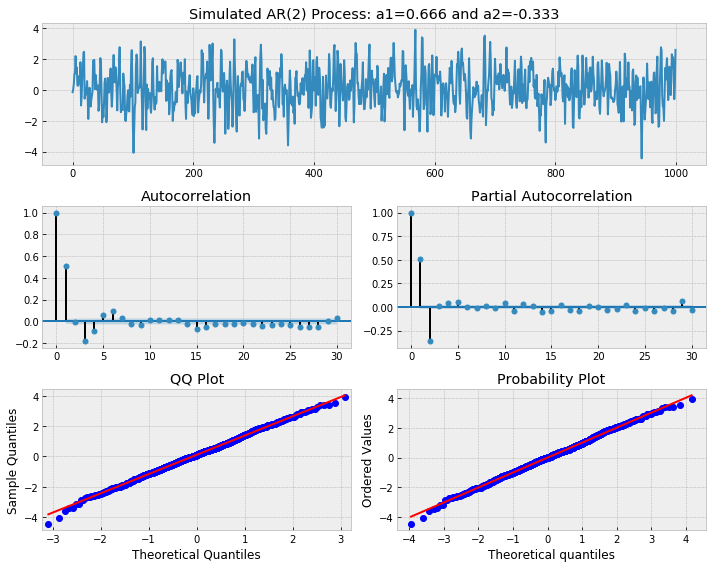

In [58]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30, title='Simulated AR(2) Process: a1={} and a2={}'.format(alphas[0], alphas[1]))

- Now try and recover the parameters

In [66]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order(maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
p('\ncoef estimate: {:3.4f} {:3.4f} | best lag order = {}'.format(mdl.params[0],mdl.params[1], est_order))
p('\ntrue coefs = {} | true order = {}'.format([.666,-.333], true_order))
  
# coef estimate: 0.6291 -0.3196 | best lag order = 2
# true coefs = [0.666, -0.333] | true order = 2


coef estimate: 0.7000 -0.3617 | best lag order = 2

true coefs = [0.666, -0.333] | true order = 2


## Now try and fit AR(p) model to MSFT log Returns

- Log returns from early in notebook dataframe lrets.
- First plot the series

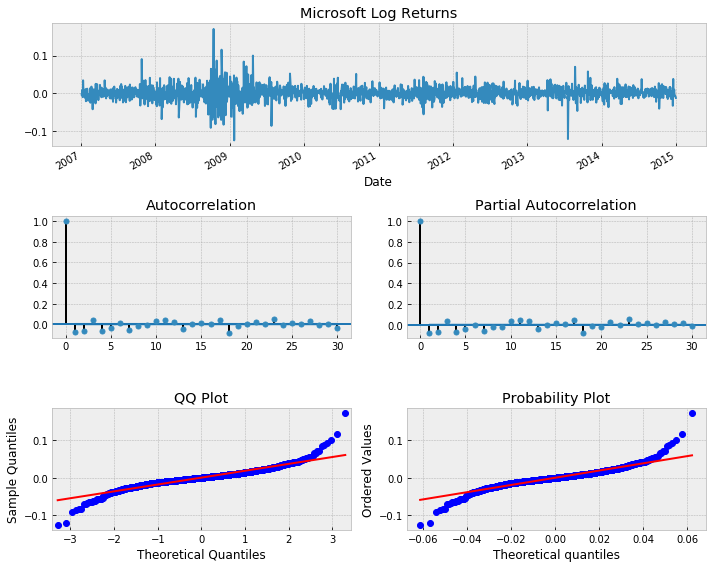

In [74]:
_ = tsplot(lrets.MSFT, lags=30, title='Microsoft Log Returns')

In [76]:
# Select best lag order for MSFT returns
import warnings
warnings.filterwarnings('ignore')
max_lag = 30
mdl = smt.AR(lrets.MSFT).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets.MSFT).select_order(maxlag=max_lag, ic='aic', trend='nc')

p('best estimated lag order = {}'.format(est_order))

best estimated lag order = 23


- Means best order would include 23 lag parameters.
- Highly unlikely to be useful in practice.
- Clearly some underlying complexity not provided in this

## Moving Average Models - MA(q)

- MA(q) models are very similiar to AR(p) models
- Difference is MA(q) model is __linear combination__ of past __white noise__ error terms as opposed to a __linear combination__ of past observations like in AR(p)

- Moving Average: Linear Combo of past error terms
- AutoRegressive: Linear Combo of past observations

- MA models can observe "shocks" in the error process directly by fitting a model to the error terms
- In AR(p) models, these shocks are observed indirectly by using ACF on a series of past observations

#### MA(q) Model:
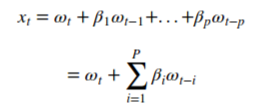

- Omega (w) - white noise
- has Expectation E(wt) = 0
- variance is sigma squared

#### Example:
- Simulate MA process using:

1. beta = 0.6

2. alpha = 0


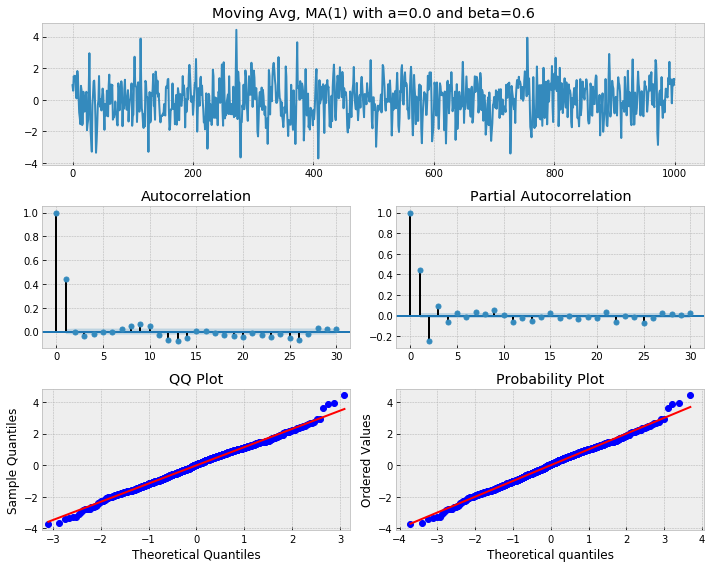

In [80]:
# Simulate an MA(1) process

n = int(1000)

# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.6])

# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ma1, lags=30, title='Moving Avg, MA(1) with a={} and beta={}'.format(alphas[0], betas[0]))

- ACF function shows that lag 1 is significant (so MA(1) may be appropriate for simulated series)
- QUESTION: Why PACF has lags > 1 when ACF does not ?
- Now attempt to fit MA(1) model to simulated data
- Use statsmodels __ARMA()__ function and call __fit()__ to return model output

In [81]:
# Fit the MA(1) model to our simulated time series
# Specify ARMA model with order (p, q)

max_lag = 30
mdl = smt.ARMA(ma1, order=(0, 1)).fit(maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 1)   Log Likelihood               -1418.517
Method:                           mle   S.D. of innovations              0.999
Date:                Sun, 20 Jan 2019   AIC                           2841.034
Time:                        11:53:35   BIC                           2850.849
Sample:                             0   HQIC                          2844.765
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.5684      0.025     22.459      0.000       0.519       0.618
                                    Roots                                    
                  Real          Imaginary           M

- Lag coef 0.5684 is close to our actual coefficient of 0.6
- 95% confidence interval does contain true value of 0.6

### Simulating MA(3)

- Use ARMA function to fit a third order MA model to the series
- Attempt to recover the correct lag coefficients (betas)
- b1 = 0.6
- b2 = 0.4
- b3 = 0.2

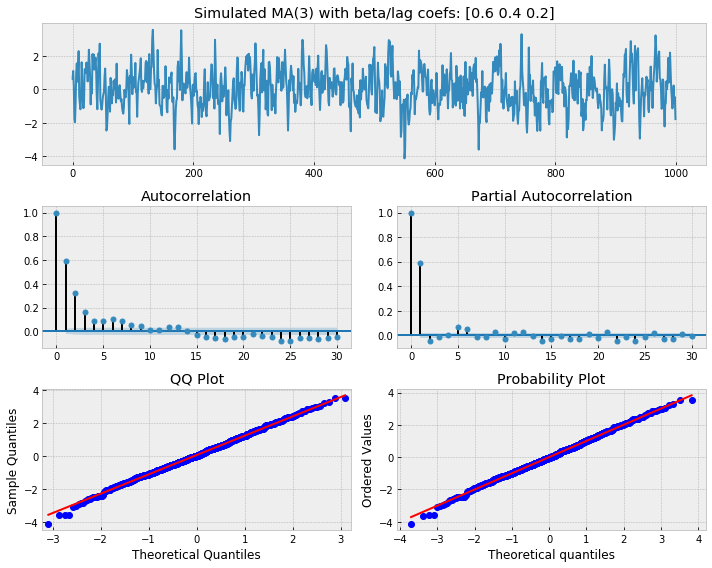

In [83]:
# Simulate MA(3) process with betas 0.6, 0.4, 0.2

n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4, 0.2])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=30, title='Simulated MA(3) with beta/lag coefs: {}'.format(betas))

In [85]:
# Fit MA(3) model to simulated time series
# Uses Maximum Likelihood Estimate

max_lag = 30
mdl = smt.ARMA(ma3, order=(0, 3)).fit(maxlag=max_lag, method='mle', trend='nc')
print(mdl.summary())

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 1000
Model:                     ARMA(0, 3)   Log Likelihood               -1366.386
Method:                           mle   S.D. of innovations              0.949
Date:                Sun, 20 Jan 2019   AIC                           2740.772
Time:                        11:57:19   BIC                           2760.403
Sample:                             0   HQIC                          2748.233
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.y        0.6118      0.031     19.772      0.000       0.551       0.672
ma.L2.y        0.3391      0.034      9.859      0.000       0.272       0.407
ma.L3.y        0.1612      0.031      5.159      0.0

- Model estimated real coefficients pretty well (0.6, 0.4, 0.2)
- 95% confidence also contains true parameter values for 0.6, 0.4, and 0.2

## Fitting MA(3) model to SPY's log returns

- keep in mind here, the true parameter is unknown 

                              ARMA Model Results                              
Dep. Variable:                    SPY   No. Observations:                 2013
Model:                     ARMA(0, 3)   Log Likelihood                5756.952
Method:                           mle   S.D. of innovations              0.014
Date:                Sun, 20 Jan 2019   AIC                         -11505.905
Time:                        12:01:03   BIC                         -11483.475
Sample:                             0   HQIC                        -11497.672
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.SPY     -0.0959      0.022     -4.314      0.000      -0.139      -0.052
ma.L2.SPY     -0.0737      0.023     -3.256      0.001      -0.118      -0.029
ma.L3.SPY      0.0274      0.022      1.260      0.2

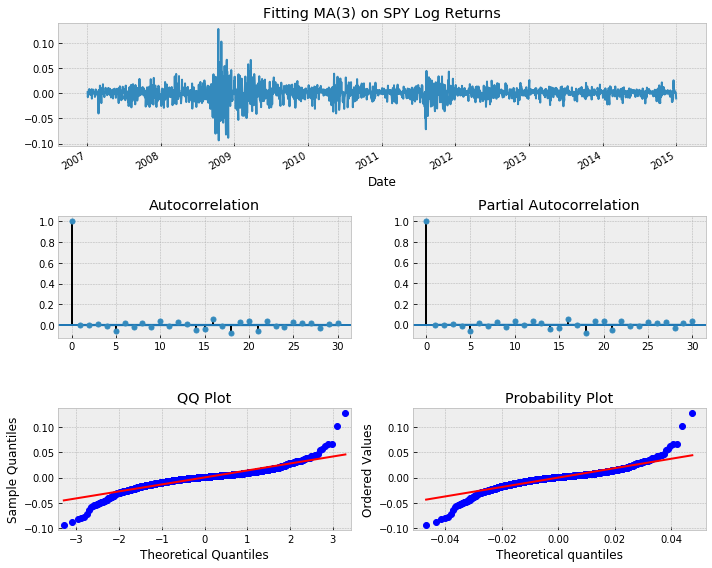

In [86]:
# Fit MA(3) to SPY returns

max_lag = 30
Y = lrets.SPY
mdl = smt.ARMA(Y, order=(0, 3)).fit(
    maxlag=max_lag, method='mle', trend='nc')
p(mdl.summary())
_ = tsplot(mdl.resid, lags=max_lag, title='Fitting MA(3) on SPY Log Returns')

- Performed ok, however some ACF Lags give reason for concern (@ 5, 16, 18)
- Could be sampling error or heaviness of tails

## Autoregressive Moving Average Models - ARMA(p,q)

- AR(p) models try to capture (explain) the momentum and mean reversion effects often observed in trading markets
- MA(q) models try to capture (explain) the shock effects observed in the white noise. Shock effects can be thought of as unexpected events affecting the observation process (e.g. suprise earnings, hurricane)
- ARMA Weakness: ignores volatility clustering effects (found in most financial TS)

#### ARMA(P,Q) Model
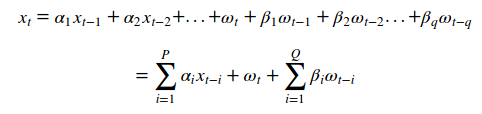

#### Example

- Simulate ARMA(2,2) with alpha and beta parameters
- Then fit an ARMA(2,2) model and see if it can correctly estimate parameters
- alphas = [0.5, -0.25]
- betas = [0.5, -0.3]

                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(2, 2)   Log Likelihood               -7121.508
Method:                           mle   S.D. of innovations              1.005
Date:                Sun, 20 Jan 2019   AIC                          14253.015
Time:                        12:32:48   BIC                          14285.601
Sample:                             0   HQIC                         14264.436
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y        0.3835      0.072      5.294      0.000       0.242       0.526
ar.L2.y       -0.2121      0.015    -13.763      0.000      -0.242      -0.182
ma.L1.y        0.5807      0.074      7.871      0.0

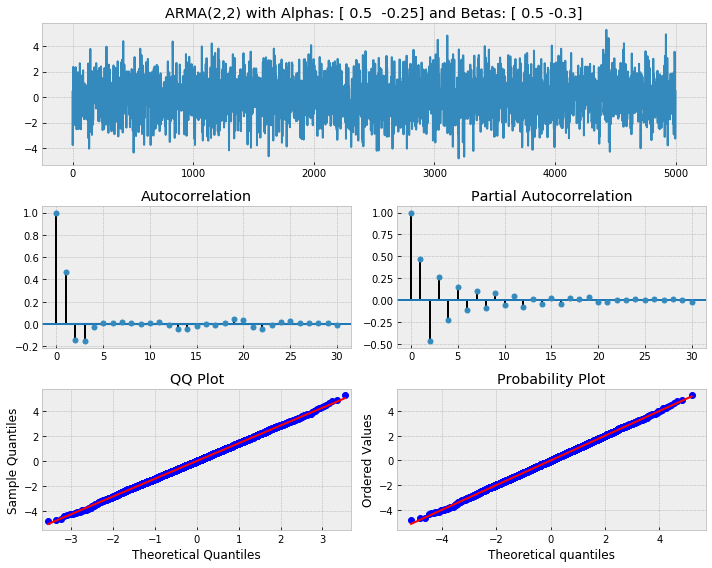

In [87]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 30

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.5, -0.25])
betas = np.array([0.5, -0.3])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag, title='ARMA(2,2) with Alphas: {} and Betas: {}'.format(alphas, betas))

mdl = smt.ARMA(arma22, order=(2, 2)).fit(maxlag=max_lag, method='mle', trend='nc', burnin=burn)
print(mdl.summary())

- Model correctly recovered parameters, and true parameters are within 95% CI

## Simulate ARMA(3,2)

- Cycle through non-trivial number of combinations of p, and q to fit an ARMA model to our simulated series
- Choose best combination based on lowest Akaike Information Criterion (AIC)

aic: 14102.96194 | order: (4, 4)
                              ARMA Model Results                              
Dep. Variable:                      y   No. Observations:                 5000
Model:                     ARMA(4, 4)   Log Likelihood               -7042.481
Method:                           mle   S.D. of innovations              0.989
Date:                Sun, 20 Jan 2019   AIC                          14102.962
Time:                        12:51:04   BIC                          14161.617
Sample:                             0   HQIC                         14123.520
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.y       -0.3785      0.046     -8.258      0.000      -0.468      -0.289
ar.L2.y        0.2182      0.035      6.150      0.000       0.149       0.288
ar.L3.y        0.10

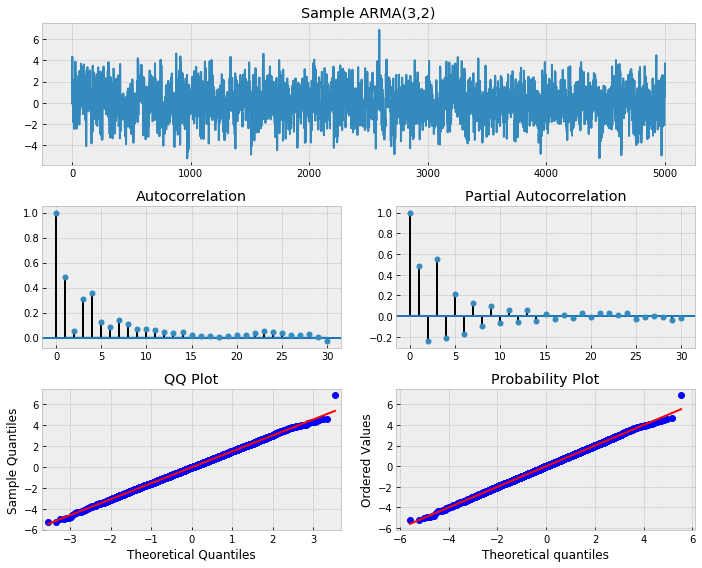

In [14]:
# Simulate an ARMA(3, 2) model with alphas=[0.5,-0.25,0.4] and betas=[0.5,-0.3]

max_lag = 30

n = int(5000)
burn = 2000

alphas = np.array([0.5, -0.25, 0.4])
betas = np.array([0.5, -0.3])

ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma32 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma32, lags=max_lag, title='Sample ARMA(3,2)')

# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma32, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            #print('i is: {} and j is: {} and AIC is: {}'.format(i,j,tmp_aic))
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except Exception as e: 
            # print('Error for AR(i): {} and MA(j): {}'.format(i,j))
            # print(e)
            continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
print(best_mdl.summary())

# Results are non-deterministic (and give different orders each run)
# Expected results:
# aic: 14108.27213 | order: (3, 2)


#### Results for graph above are not same as blog

## Fit ARMA model to SPY Returns

In [18]:
# Fit ARMA model to SPY returns

best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5) # [0,1,2,3,4,5]
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(lrets['SPY'], order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# aic: -11518.22902 | order: (4, 4)

aic: -11520.47340 | order: (4, 3)


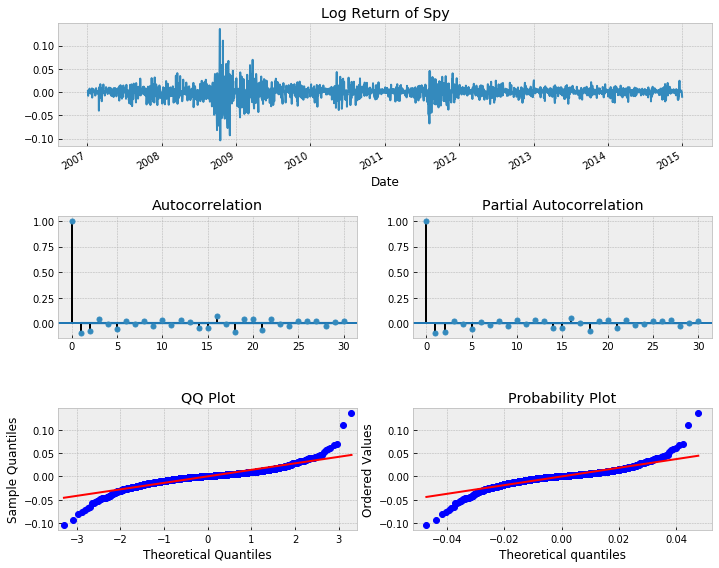

In [19]:
# Now plot the residuals
_ = tsplot(lrets['SPY'], lags=max_lag, title='Log Return of Spy')

- ACF and PACF show no significant autocorrelation
- QQ and Probability Plots show residuals are approx. normal with heavy tails
- Model residuals do __NOT__ look like white noise
- This is obvious __conditional heteroskedasticity__ (conditional volatility) that the model has not captured

## Autoregressive Integrated Moving Average Models - ARIMA(p, d, q)

- ARIMA is natural extension of ARMA models
- Many TS are nonstationary, however they can be made stationary by __differencing__
- An example of this was first difference of a Gaussian Random walked turned out to be white noise
- Said another way, took nonstationary random walk and transformed it to a stationary white noise by first-differencing

- The __d__ references the number of times we are differencing the series
- In python, must use np.diff() if we need to difference a series more than once
- Pandas DataFrame.diff() / Series.diff() only takes 1st difference and does not have recursive differencing needed in TSA!

#### Example
- Non-trivial number of combinations of (p, d, q) orders to find the best ARIMA model to fit SPY returns. 
- We use AIC to evaluate each model
- Lowest AIC means best model

aic: -11520.47340 | order: (4, 0, 3)


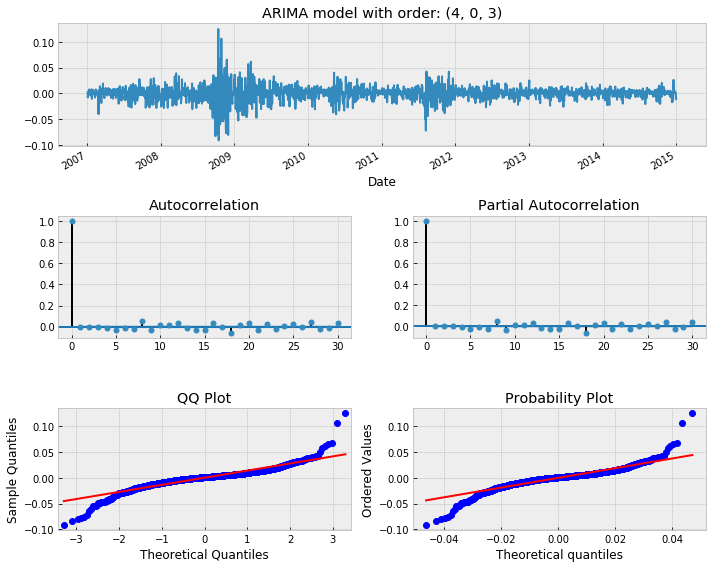

In [5]:
# Fit ARIMA(p, d, q) model to SPY Returns
# pick best order and final model based on aic

best_aic = np.inf 
best_order = None
best_mdl = None

pq_rng = range(5) # [0,1,2,3,4]
d_rng = range(2) # [0,1]
for i in pq_rng:
    for d in d_rng:
        for j in pq_rng:
            try:
                tmp_mdl = smt.ARIMA(lrets.SPY, order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
# aic: -11518.22902 | order: (4, 0, 4)

# ARIMA model resid plot
_ = tsplot(best_mdl.resid, lags=30, title='ARIMA model with order: {}'.format(best_order))

- No surprise best model has a differencing of 0
- Recall, already took first difference of log prices to calculate stock returns
- Result is essentially identical to ARMA(4,4)
- Clearly this ARIMA model has not explained the conditional volatility in the series either


## Forecasting

- Here we will make use of forecasting using our models __forecast()__ method
- Arguments include:
1) number of time steps to predict (int)
2) alpha argument to specify condfience intervals (decimal)
- Default 95% CI
- For 99% CI set alpha equal to 0.01

In [41]:
# Create a 21 day forecast of SPY returns with 95%, 99% CI
n_steps = 21

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

idx = pd.date_range(data.index[-1], periods=n_steps, freq='D')
fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]),  index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2014-12-31,0.001367,-0.025642,-0.034129,0.028376,0.036863
2015-01-01,-0.000068,-0.027192,-0.035715,0.027056,0.035579
2015-01-02,0.000230,-0.026954,-0.035495,0.027413,0.035954
2015-01-03,0.000454,-0.026736,-0.035280,0.027644,0.036187
2015-01-04,-0.000608,-0.027798,-0.036342,0.026583,0.035126


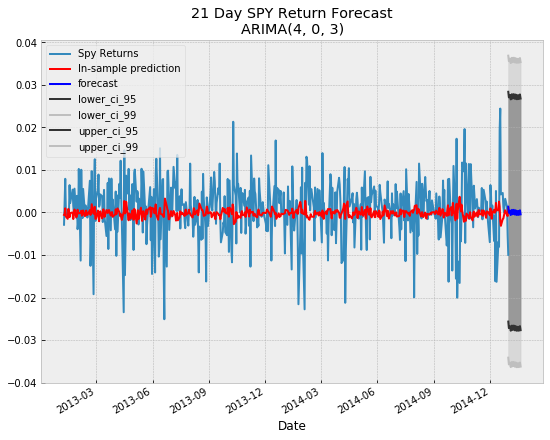

In [42]:
# Plot 21 day forecast for SPY returns

plt.style.use('bmh')
fig = plt.figure(figsize=(9,7))
ax = plt.gca()

ts = lrets.SPY.iloc[-500:].copy()
ts.plot(ax=ax, label='Spy Returns')
# in sample prediction

# ts is our sample, we need to find the start of the time series index
# ts.index[0]  == Timestamp('2013-01-08 00:00:00') [which does not work for whatever reason in example]
# best_mdl.resid.loc[ts.index[0]] == -0.0023223317874192175
# which gives us the iloc of our TS data from the model

fcast_start = pd.Index(best_mdl.resid).get_loc(best_mdl.resid.loc[ts.index[0]])
fcast_end = pd.Index(best_mdl.resid).get_loc(best_mdl.resid.loc[ts.index[-1]])

pred = best_mdl.predict(start=fcast_start, end=fcast_end)
pred.plot(ax=ax, style='r-', label='In-sample prediction')

styles = ['b-', '0.2', '0.75', '0.2', '0.75']
fc_all.plot(ax=ax, style=styles)
plt.fill_between(fc_all.index, fc_all.lower_ci_95, fc_all.upper_ci_95, color='gray', alpha=0.7)
plt.fill_between(fc_all.index, fc_all.lower_ci_99, fc_all.upper_ci_99, color='gray', alpha=0.2)
plt.title('{} Day SPY Return Forecast\nARIMA{}'.format(n_steps, best_order))
plt.legend(loc='best', fontsize=10)

## Autoregressive Conditionally Heteroskedastic Models - ARCH(p)

- ARCH(p) are simply AR(p) model applied to the __variance__ of a time series
- The variance of our time series NOW at time t, is conditional on past observations of the variance in previous periods

#### ARCH(1)
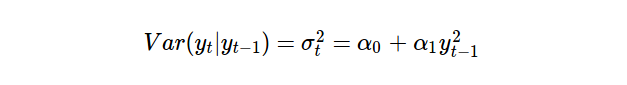

- Assuming the series has zero mean, the model can be expressed as:
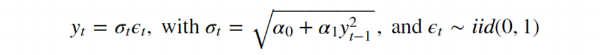

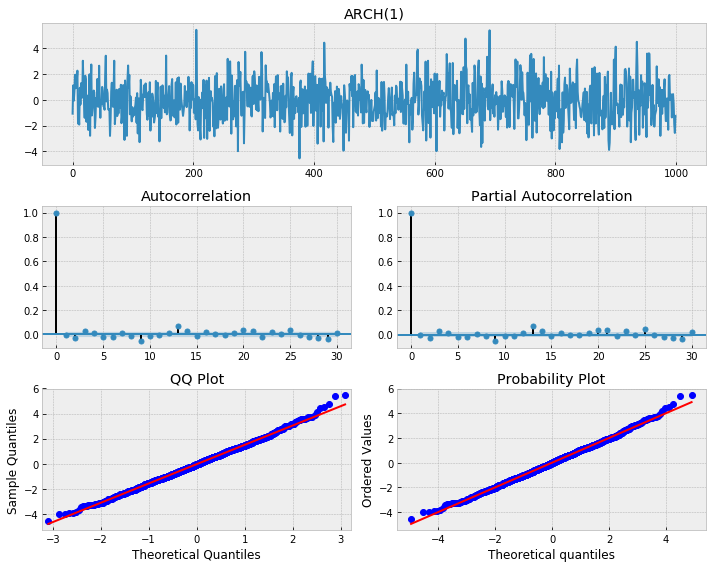

In [45]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30, title='ARCH(1)')

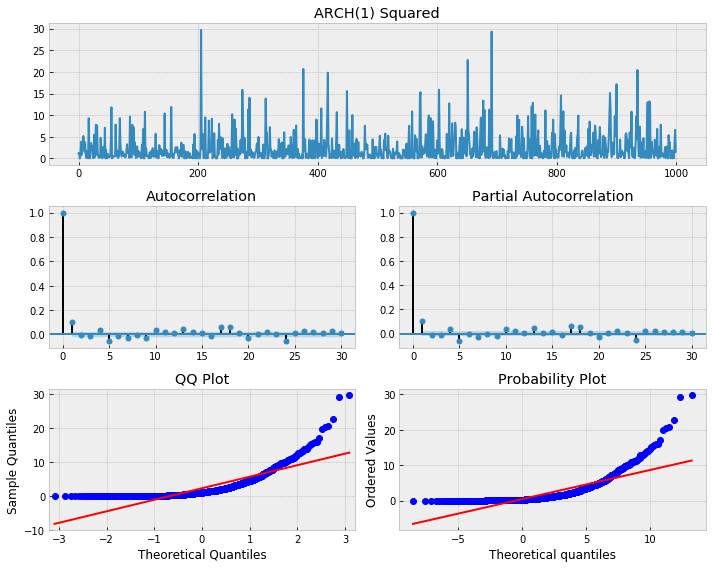

In [48]:
# Simulate ARCH(1) series
# Var(yt) = a_0 + a_1*y{t-1}**2
# if a_1 is between 0 and 1 then yt is white noise

np.random.seed(13)

a0 = 2
a1 = .5

y = w = np.random.normal(size=1000)
Y = np.empty_like(y)

for t in range(len(y)):
    Y[t] = (w[t] * np.sqrt((a0 + a1*y[t-1]**2)))**2

# simulated ARCH(1) series, looks like white noise
tsplot(Y, lags=30, title='ARCH(1) Squared')

- ACF and PACF show significance at lag 1 
- Indicates ARCH(1) model for the variance may be appropriate

## Generalized Autoregressive Conditionally Heteroskedastic Models GARCH(p, q)

- GARCH(p, q) is an ARMA model applied to the variance of a time series
- It has an autoregressive term and a moving average term
- AR(p) models the variance of the residuals (squared errors), or simply our time series squared
- MA(q) portion models the variance of the process

#### GARCH(1,1):
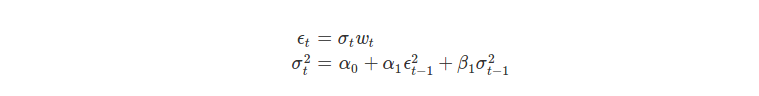

- Omega (w) - white noise
- Alpha (a) - parameter (alpha_1 must be less than 1, or model is unstable)
- Beta  (b) - parameter (beta_1 must be less than 1, or model is unstable)

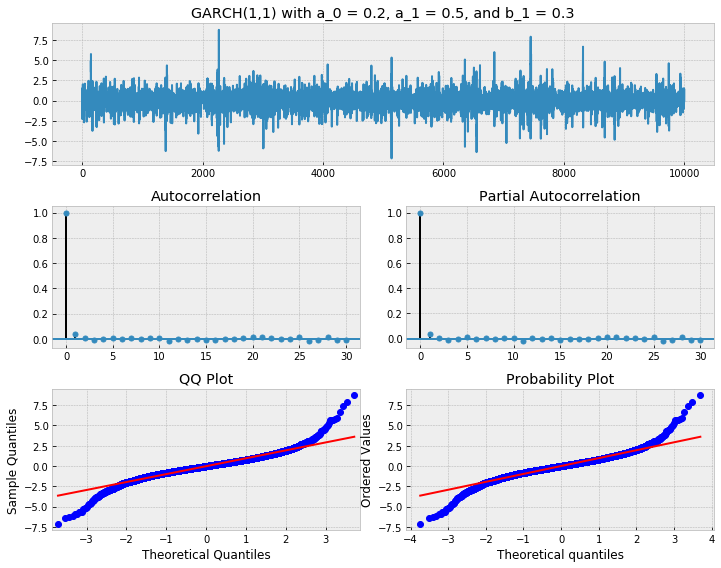

In [50]:
# Simulating a GARCH(1, 1) process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])

_ = tsplot(eps, lags=30, title='GARCH(1,1) with a_0 = {}, a_1 = {}, and b_1 = {}'.format(a0, a1, b1))

- Process closely resembles that of white noise
- But when ran again with squared eps series

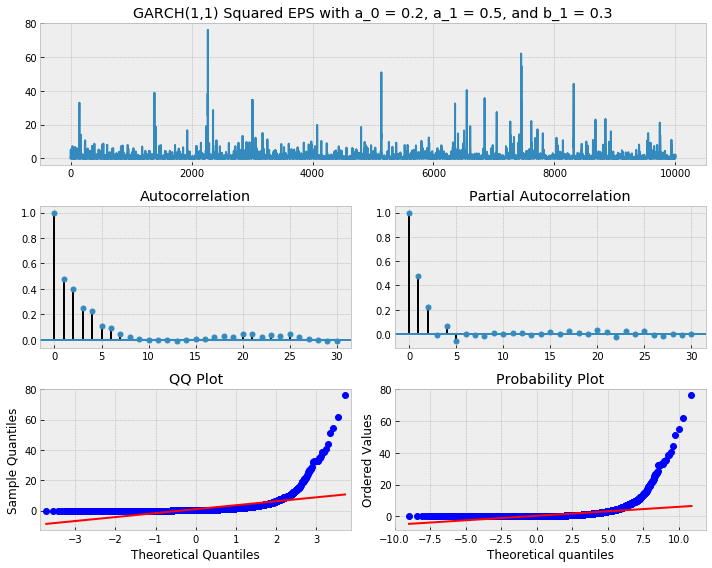

In [53]:
# Simulating a GARCH(1, 1) Squared EPS process

np.random.seed(2)

a0 = 0.2
a1 = 0.5
b1 = 0.3

n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)

for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])
    
_ = tsplot(eps**2, lags=30, title='GARCH(1,1) Squared EPS with a_0 = {}, a_1 = {}, and b_1 = {}'.format(a0, a1, b1))

- Clearly autocorrelation present
- Significance of the lags in both ACF and PACF indicate we need both AR and MA components for our model
- Now try and attempt to recover our process parameters using a GARCH(1,1) model
- Here we make use of __arch_model__ from the __ARCH__ package

In [55]:
# Fit a GARCH(1, 1) model to our simulated EPS series
# We use the arch_model function from the ARCH package

am = arch_model(eps)
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592658753043
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 12237.30326731947
            Iterations: 13
            Function evaluations: 89
            Gradient evaluations: 13
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -12237.3
Distribution:                  Normal   AIC:                           24482.6
Method:            Maximum Likelihood   BIC:                           24511.4
                                        No. Observations:                10000
Date:                Sun, Jan 20 2019   Df Residuals:                     9996
Time:       

## GARCH process using SPY Returns

- Iterate through combinations of ARIMA(p, d, q) models to best fit our time series
- Pick the GARCH model orders according to the ARIMA model with lowest AIC
- Fit the GARCH(p, q) model to our time series
- Examine the model residuals and squared residuals for autocorrelation 
- Results vary depending on the time period chosen

In [57]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None

    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl

# Notice I've selected a specific time period to run this analysis
TS = lrets.SPY.ix['2012':'2015']
res_tup = _get_best_model(TS)

# aic: -5255.56673 | order: (3, 0, 2)

aic: -5255.56617 | order: (3, 0, 2)


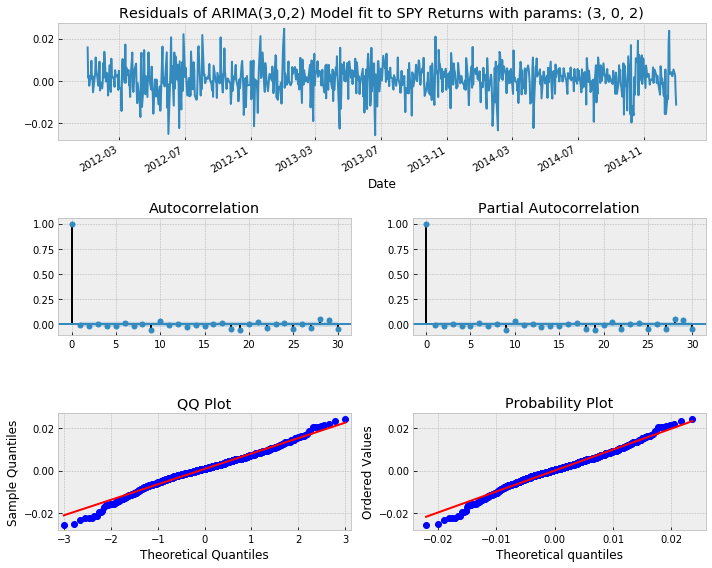

In [77]:
_ = tsplot(res_tup[2].resid, lags=30, title='Residuals of ARIMA(3,0,2) Model fit to SPY Returns with params: {}'.format(res_tup[1]))

- Now again with residuals squared

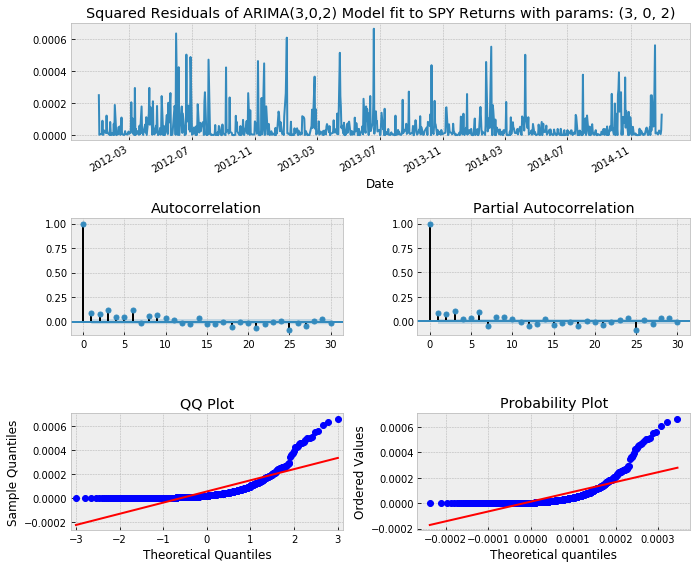

In [78]:
_ = tsplot((res_tup[2].resid)**2, lags=30, title='Squared Residuals of ARIMA(3,0,2) Model fit to SPY Returns with params: {}'.format(res_tup[1]))

- Squared residuals show autocorrelation. 
- Now fit a GARCH model and see how it does

In [70]:
# Now we can fit the arch model using the best fit arima model parameters
order = res_tup
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(TS, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                          SPY   R-squared:                -2831458.509
Mean Model:                   Constant Mean   Adj. R-squared:           -2831458.509
Vol Model:                            GARCH   Log-Likelihood:               -3849.25
Distribution:      Standardized Student's t   AIC:                           7714.50
Method:                  Maximum Likelihood   BIC:                           7751.51
                                              No. Observations:                  754
Date:                      Sun, Jan 20 2019   Df Residuals:                      746
Time:                              14:48:16   Df Model:                            8
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            12

C:\Users\Justin\Anaconda3\envs\myPython36\lib\site-packages\arch\univariate\base.py:571: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


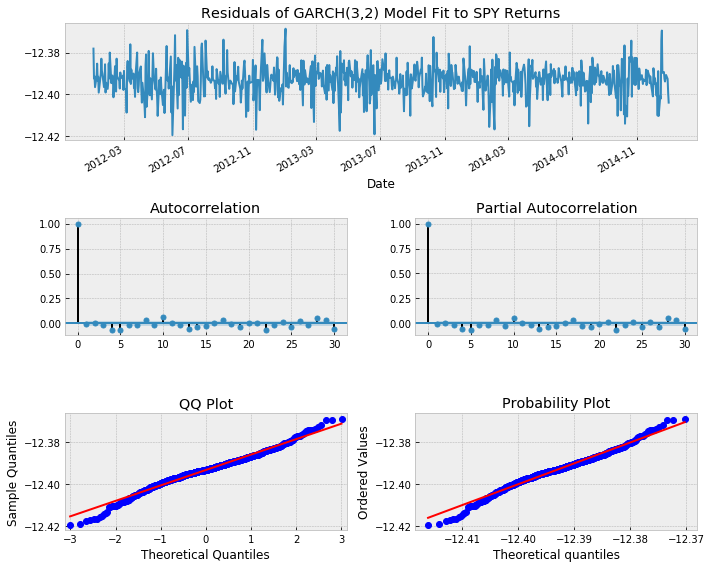

In [79]:
_ = tsplot(res.resid, lags=30, title='Residuals of GARCH(3,2) Model Fit to SPY Returns')

- Now try the fitted GARCH(1,1) with squared residuals

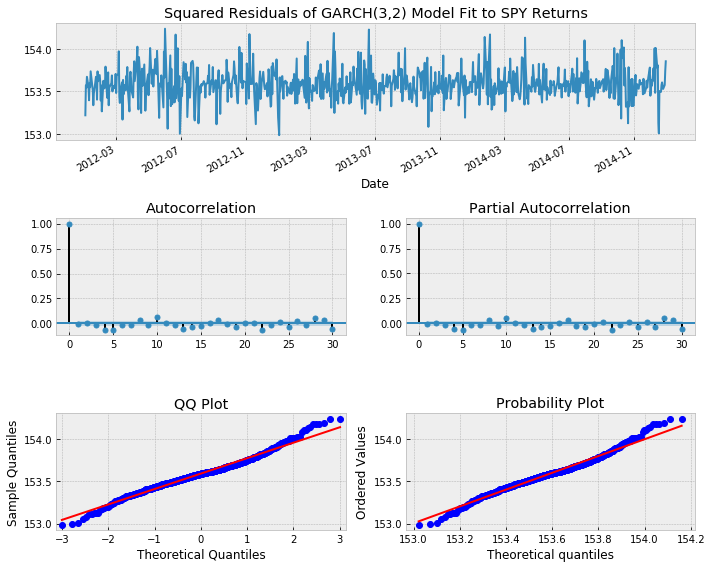

In [80]:
_ = tsplot((res.resid)**2, lags=30, title='Squared Residuals of GARCH(3,2) Model Fit to SPY Returns')

- Looks like we have achieved a good model fit as there is no obvious autocorrelation in the squared residuals

## References

- Blackarbs.com - http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016

- Quantstart.com - https://www.quantstart.com/articles#time-series-analysis

- Harvard Lectures in Python - http://iacs-courses.seas.harvard.edu/courses/am207/blog/lecture-17.html

- Penn State Stats - https://onlinecourses.science.psu.edu/stat510/node/78

- stationary pic + tsplot - http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/

- stationary quote, etc - http://people.duke.edu/~rnau/411diff.htm

- interpreting qq plots - http://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot

- Kaplan SchweserNotes (Level 2) - Quantitative Methods
